# Load and transform data 

In [1]:

import numpy as np
import os
import gzip

def load_data(data_folder):

  files = [
      'train-labels-idx1-ubyte.gz', 'train-images-idx3-ubyte.gz',
      't10k-labels-idx1-ubyte.gz', 't10k-images-idx3-ubyte.gz'
  ]

  paths = []
  for fname in files:
    paths.append(os.path.join(data_folder,fname))

  with gzip.open(paths[0], 'rb') as lbpath:
    y_train = np.frombuffer(lbpath.read(), np.uint8, offset=8)

  with gzip.open(paths[1], 'rb') as imgpath:
    x_train = np.frombuffer(
        imgpath.read(), np.uint8, offset=16).reshape(len(y_train), 28, 28)

  with gzip.open(paths[2], 'rb') as lbpath:
    y_test = np.frombuffer(lbpath.read(), np.uint8, offset=8)

  with gzip.open(paths[3], 'rb') as imgpath:
    x_test = np.frombuffer(
        imgpath.read(), np.uint8, offset=16).reshape(len(y_test), 28, 28)

  return (x_train, y_train), (x_test, y_test)

(X_train, y_train), (X_test, y_test) = load_data('/Users/tmh/Desktop/massive data/hw1/MNIST/')

print('Training Data: {}'.format(X_train.shape))
print('Training Labels: {}'.format(y_train.shape))
print('Testing Data: {}'.format(X_test.shape))
print('Testing Labels: {}'.format(y_test.shape))


Training Data: (60000, 28, 28)
Training Labels: (60000,)
Testing Data: (10000, 28, 28)
Testing Labels: (10000,)


In [2]:
# preprocessing the images
# convert each image to 1 dimensional array
X_train = X_train.reshape(len(X_train),-1)
X_test = X_test.reshape(len(X_test),-1)

# normalize the data to 0 - 1
X_train = X_train.astype(float) / 255.
X_test = X_test.astype(float) / 255.
print(X_train.shape)
print(X_train[0].shape)
print(X_test.shape)
print(X_test[0].shape)

(60000, 784)
(784,)
(10000, 784)
(784,)


In [3]:
np.savetxt('X_train.csv', X_train, delimiter = ',')
np.savetxt('X_test.csv', X_test, delimiter = ',')
np.savetxt('y_train.csv', y_train, delimiter = ',')
np.savetxt('y_test.csv', y_test, delimiter = ',')

In [4]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Pyspark_kmeans_MNIST") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

In [68]:
X_train = spark.read.format('com.databricks.spark.csv').\
                       options(header='true', \
                       inferschema='true').\
            load("../MNIST/X_train.csv",header=None);
X_test = spark.read.format('com.databricks.spark.csv').\
                       options(header='true', \
                       inferschema='true').\
            load("../MNIST/X_test.csv",header=None);

In [69]:
print((X_train.count(), len(X_train.columns)))
print((X_test.count(), len(X_test.columns)))

(60000, 784)
(10000, 784)


In [70]:
from pyspark.ml.feature import VectorAssembler
FEATURE_NUM = 784
# assemble those features to a vector to consume in Spark
assembler = VectorAssembler(
    inputCols=["_c{0}".format(i) for i in range(FEATURE_NUM)],
    outputCol="features")

# Transform pixel0,pixel1...pixel783 to one column named "features"
X_train = assembler.transform(X_train).select("features")
X_test = assembler.transform(X_test).select("features")


In [71]:
#X_train= transData(X_train)
X_train.show(5,True)
#X_test= transData(X_test)
X_test.show(5,True)

+--------------------+
|            features|
+--------------------+
|(784,[152,153,154...|
|(784,[127,128,129...|
|(784,[160,161,162...|
|(784,[158,159,160...|
|(784,[208,209,210...|
+--------------------+
only showing top 5 rows

+--------------------+
|            features|
+--------------------+
|(784,[202,203,204...|
|(784,[94,95,96,97...|
|(784,[128,129,130...|
|(784,[124,125,126...|
|(784,[150,151,159...|
+--------------------+
only showing top 5 rows



# Spark K-means

In [84]:
import sys

import numpy as np
from pyspark.sql import SparkSession


def parseVector(line):
    return np.array([float(x) for x in line.split(' ')])


def closestPoint(p, centers):
    bestIndex = 0
    closest = float("+inf")
    for i in range(len(centers)):
        tempDist = np.sum((p - centers[i]) ** 2)
        if tempDist < closest:
            closest = tempDist
            bestIndex = i
    return bestIndex


if __name__ == "__main__":

    if len(sys.argv) != 4:
        print("Usage: kmeans <file> <k> <convergeDist>", file=sys.stderr)
        sys.exit(-1)

    print("""WARN: This is a naive implementation of KMeans Clustering and is given
       as an example! Please refer to examples/src/main/python/ml/kmeans_example.py for an
       example on how to use ML's KMeans implementation.""", file=sys.stderr)

    spark = SparkSession\
        .builder\
        .appName("PythonKMeans")\
        .getOrCreate()

    lines = spark.read.text(sys.argv[1]).rdd.map(lambda r: r[0])
    data = lines.map(parseVector).cache()
    K = int(sys.argv[2])
    convergeDist = float(sys.argv[3])

    kPoints = data.takeSample(False, K, 1)
    tempDist = 1.0

    while tempDist > convergeDist:
        closest = data.map(
            lambda p: (closestPoint(p, kPoints), (p, 1)))
        pointStats = closest.reduceByKey(
            lambda p1_c1, p2_c2: (p1_c1[0] + p2_c2[0], p1_c1[1] + p2_c2[1]))
        newPoints = pointStats.map(
            lambda st: (st[0], st[1][0] / st[1][1])).collect()

        tempDist = sum(np.sum((kPoints[iK] - p) ** 2) for (iK, p) in newPoints)

        for (iK, p) in newPoints:
            kPoints[iK] = p

    print("Final centers: " + str(kPoints))

    spark.stop()

Usage: kmeans <file> <k> <convergeDist>


SystemExit: -1

In [73]:
from pyspark.ml.clustering import KMeans
import numpy as np
cost = np.zeros(20)
for k in range(2,20):
    kmeans = KMeans()\
            .setK(k)\
            .setSeed(1) \
            .setFeaturesCol("features")\
            .setPredictionCol("cluster")

    model = kmeans.fit(X_train)
    cost[k] = model.computeCost(X_train) 

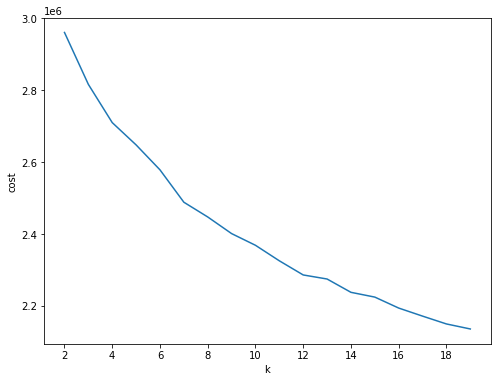

In [14]:
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import seaborn as sbs
from matplotlib.ticker import MaxNLocator

fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,20),cost[2:20])
ax.set_xlabel('k')
ax.set_ylabel('cost')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

In [74]:
from pyspark.ml import Pipeline
kmeans = KMeans() \
          .setK(256) \
          .setFeaturesCol("features")\
          .setPredictionCol("cluster")

model = kmeans.fit(X_train)
cluster = model.transform(X_train).select('cluster').collect()
predlabels = [c.cluster for c in cluster ]


In [75]:
from sklearn.metrics import accuracy_score
#y_train=y_train.tolist()
accuracy_score(y_train, predlabels)


0.00031666666666666665

 We can see the accuracy is extremely low, this is because K-means is an unsupervised learning, the predicted cluster number was given randomly. Therefore, to calculate the accuracy, we should map the predicted cluster numbers with the real numbers.

# Assigning Cluster Labels

In [17]:

predlabels = np.array(predlabels)

def infer_cluster_labels(kmeans, actual_labels):
    """
    Associates most probable label with each cluster in KMeans model
    returns: dictionary of clusters assigned to each label
    """

    inferred_labels = {}

    for i in range(256):

        # find index of points in cluster
        labels = []
        index = np.where(predlabels == i)  #预测的cluster=1的序号

        # append actual labels for each point in cluster
        labels.append(y_train[index])  #这些位置真实的序号在labels里

        # determine most common label
        if len(labels[0]) == 1:
            counts = np.bincount(labels[0])    #进到labels的第一个array里，查升序10个索引出现的次数np.bincount count(indexappears)
        else:
            counts = np.bincount(np.squeeze(labels)) # 在机器学习和深度学习中，通常算法的结果是可以表示向量的数组（即包含两对或以上的方括号形式[[]]），如果直接利用这个数组进行画图可能显示界面为空（见后面的示例）。我们可以利用squeeze（）函数将表示向量的数组转换为秩为1的数组，这样利用matplotlib库函数画图时，就可以正常的显示结果了。


        # assign the cluster to a value in the inferred_labels dictionary
        if np.argmax(counts) in inferred_labels:   #出现次数最多的那个index
            # append the new number to the existing array at this slot
            inferred_labels[np.argmax(counts)].append(i)    # {5: [i, 1, 1]} 如果在里面就继续写i  5是真的
        else:
            # create a new array in this slot
            inferred_labels[np.argmax(counts)] = [i]    #不在就创建{5: [1]}
        
    return inferred_labels  

#以上表示预测的cluster=1里面的点 最多聚集在真实的聚类5那里， i个预测cluster的时候 得到聚集在真实聚类处 各个预测cluster的值


def infer_data_labels(X_labels, cluster_labels):
    """
    Determines label for each array, depending on the cluster it has been assigned to.
    returns: predicted labels for each array
    """
    
    # empty array of len(X)
    predicted_labels = np.zeros(len(X_labels)).astype(np.uint8)  
    
    for i, cluster in enumerate(X_labels):   #enumerate 同时输出索引和索引处的值
        for key, value in cluster_labels.items():
            if cluster in value:
                predicted_labels[i] = key
                
    return predicted_labels   #把预测的用真实填写

In [18]:
y_train=np.array(y_train)
predlabels = np.array(predlabels)
# test the infer_cluster_labels() and infer_data_labels() functions

cluster_labels = infer_cluster_labels(model, y_train)


predicted_labels = infer_data_labels(predlabels, cluster_labels)
print (predicted_labels[:20])
print (y_train[:20])

[5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8 6 9]
[5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8 6 9]


In [19]:
from sklearn.metrics import accuracy_score
#y_train=y_train.tolist()
accuracy_score(y_train, predicted_labels)


0.9086666666666666

The accuracy increased a lot, well done!!!

# Test on test data

In [78]:
y_test=np.array(y_test)
predlabels = np.array(predlabels)
# test the infer_cluster_labels() and infer_data_labels() functions

cluster_test = model.transform(X_test).select('cluster').collect()
predlabels_test = [c.cluster for c in cluster_test ]
predlabels_test = np.array(predlabels_test)
cluster_labels_test = infer_cluster_labels(model_test, y_test)


predicted_labels_test = infer_data_labels(predlabels_test, cluster_labels_test)
print (predicted_labels_test[:20])
print (y_test[:20])

[7 2 1 0 4 1 9 3 5 9 0 6 9 0 1 5 9 7 5 4]
[7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4]


In [79]:
from sklearn.metrics import accuracy_score
#y_train=y_train.tolist()
accuracy_score(y_test, predicted_labels_test)


0.9145